# Trabajo Práctico 3

# Imports y función de entrenamiento

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn as sk
import pandas as pd
from sklearn.neural_network import MLPRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error, zero_one_loss, accuracy_score
from sklearn.model_selection import train_test_split
import copy
import math
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.naive_bayes import GaussianNB

warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [5]:
#función que entrena una red ya definida previamente "evaluaciones" veces, cada vez entrenando un número de épocas elegido al crear la red y midiendo el error en train, validación y test al terminar ese paso de entrenamiento.
#Guarda y devuelve la red en el paso de evaluación que da el mínimo error de validación
#entradas: la red, las veces que evalua, los datos de entrenamiento y sus respuestas, de validacion y sus respuestas, de test y sus respuestas
#salidas: la red entrenada en el mínimo de validación, los errores de train, validación y test medidos en cada evaluación
def entrenar_red(red, evaluaciones, X_train, y_train, X_val, y_val, X_test, y_test):
    if type(red) == MLPRegressor:
      error_fun = mean_squared_error
    else:
      error_fun = zero_one_loss

    best_red = red
    best_red_error = 1.0
    error_train = []
    error_val = []
    error_test = []

    for i in range(evaluaciones):
      red.fit(X_train, y_train)

      P_train = red.predict(X_train)
      error_train.append(error_fun(y_train, P_train))

      P_val = red.predict(X_val)
      red_error_val = error_fun(y_val, P_val)
      error_val.append(red_error_val)

      P_test = red.predict(X_test)
      error_test.append(error_fun(y_test, P_test))

      if red_error_val < best_red_error:
        best_red = copy.deepcopy(red)
        best_red_error = red_error_val

    return best_red, error_train, error_val, error_test

In [6]:
def entrenar_red_weight_decay(red, evaluaciones, X_train, y_train, X_test, y_test, weight_fun = np.square):
    if type(red) == MLPRegressor:
      error_fun = mean_squared_error
    else:
      error_fun = zero_one_loss

    error_train = []
    error_test = []
    weight_sum = []

    for i in range(evaluaciones):
      red.fit(X_train, y_train)

      P_train = red.predict(X_train)
      error_train.append(error_fun(y_train, P_train))

      P_test = red.predict(X_test)
      error_test.append(error_fun(y_test, P_test))

      weight_sum.append(np.sum([np.sum(weight_fun(w)) for w in red.coefs_]))

    return red, error_train, error_test, weight_sum

In [7]:
def cargar_csv(path, xcols=2, delim_whitespace=False):
    """
    Argumentos:
      path (str): ruta al archivo csv a cargar
      xcols (int): cantidad de columnas que representan las entradas,
        la columna restante representara la clase o dato de salida
    """
    df = pd.read_csv(path, delim_whitespace=delim_whitespace, header=None)
    X = df.loc[:, 0:(xcols-1)]
    y = df.loc[:, xcols]
    return X,y

## Espirales

Generar n datos. De los n puntos generados, n/2 deben pertenecer a cada clase.

Los datos tienen 2 inputs, x e y, que corresponden a puntos generados al azar con una distribución UNIFORME (en dicho sistema de referencia x-y) dentro de un circulo de radio 1.

El output es binario, correspondiendo la clase 0 a los puntos que se encuentran entre las curvas ro = theta/4pi y ro = (theta + pi)/4pi (en polares) y la clase 1 al resto.

In [103]:
def cartesian_to_polar(x, y):
    rho = (x**2 + y**2)**0.5
    theta = math.atan2(y, x)
    return rho, theta

def is_inside_curve(rho, theta, npi):
  rho_curve1 = (theta + (npi-1)*math.pi) / (4 * math.pi)
  rho_curve2 = (theta + npi*math.pi) / (4 * math.pi)
  return rho_curve1 <= rho <= rho_curve2

def is_inside_curves(x, y):
    rho, theta = cartesian_to_polar(x, y)
    return is_inside_curve(rho, theta, 1) or is_inside_curve(rho, theta, 3) or is_inside_curve(rho, theta, 5)

def espirales(n):
  count0 = 0
  count1 = 0
  l = []
  while (count0 + count1) < n:
    x = np.random.uniform(-1, 1, 1)
    y = np.random.uniform(-1, 1, 1)
    if ((x**2 + y**2)**0.5 < 1): # si esta adentro del circulo
      if (is_inside_curves(x, y)):
        if count0 < int(n/2):
          l.append([x, y, 0])
          count0+=1
      else:
        if count1 < int(n/2):
          l.append([x, y, 1])
          count1+=1
  df = pd.DataFrame(l, columns=['dim_1', 'dim_2', 'class'])
  return df

## Entrenamiento Redes

In [104]:
redes = {}

#defino parámetros de la red
epocas_por_entrenamiento=20     #numero de epocas que entrena cada vez
eta=0.1                         #learning rate
alfa=0.9                        #momentum
evaluaciones = 1000

In [105]:
df_train = espirales(600)
train_target = df_train["class"].to_numpy()
train_data = df_train.drop(columns=["class"]).to_numpy()
X_train, X_val, y_train, y_val = train_test_split(train_data, train_target, test_size = 0.2)

df_test = espirales(2000)
feature_names = list(df_test.columns.values)[:-1]
y_test = df_test["class"].to_numpy()
X_test = df_test.drop(columns=["class"]).to_numpy()

### Red 2 hidden

In [106]:
N2 = 2

clasif = MLPClassifier(hidden_layer_sizes=(N2,), activation='logistic', solver='sgd', alpha=0.0, batch_size=1, learning_rate='constant', learning_rate_init=eta,momentum=alfa,nesterovs_momentum=False,tol=0.0,warm_start=True,max_iter=epocas_por_entrenamiento)

best_red, error_train, error_val, error_test = entrenar_red(clasif, evaluaciones, X_train, y_train, X_val, y_val, X_test, y_test)
redes[N2] = best_red

### Red 10 hidden

In [107]:
N2 = 10

clasif = MLPClassifier(hidden_layer_sizes=(N2,), activation='logistic', solver='sgd', alpha=0.0, batch_size=1, learning_rate='constant', learning_rate_init=eta,momentum=alfa,nesterovs_momentum=False,tol=0.0,warm_start=True,max_iter=epocas_por_entrenamiento)

best_red, error_train, error_val, error_test = entrenar_red(clasif, evaluaciones, X_train, y_train, X_val, y_val, X_test, y_test)
redes[N2] = best_red

### Red 20 hidden

In [135]:
N2 = 20

clasif = MLPClassifier(hidden_layer_sizes=(N2,), activation='logistic', solver='sgd', alpha=0.0, batch_size=1, learning_rate='constant', learning_rate_init=eta,momentum=alfa,nesterovs_momentum=False,tol=0.0,warm_start=True,max_iter=epocas_por_entrenamiento)

best_red, error_train, error_val, error_test = entrenar_red(clasif, evaluaciones, X_train, y_train, X_val, y_val, X_test, y_test)
redes[N2] = best_red

### Red 40 hidden

In [131]:
N2 = 40

clasif = MLPClassifier(hidden_layer_sizes=(N2,), activation='logistic', solver='sgd', alpha=0.0, batch_size=1, learning_rate='constant', learning_rate_init=eta,momentum=alfa,nesterovs_momentum=False,tol=0.0,warm_start=True,max_iter=epocas_por_entrenamiento)

best_red, error_train, error_val, error_test = entrenar_red(clasif, evaluaciones, X_train, y_train, X_val, y_val, X_test, y_test)
redes[N2] = best_red

## Gráficos

C:\Users\Certi\AppData\Local\Temp\ipykernel_27788\2214307645.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(
C:\Users\Certi\AppData\Local\Temp\ipykernel_27788\2214307645.py:15: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(


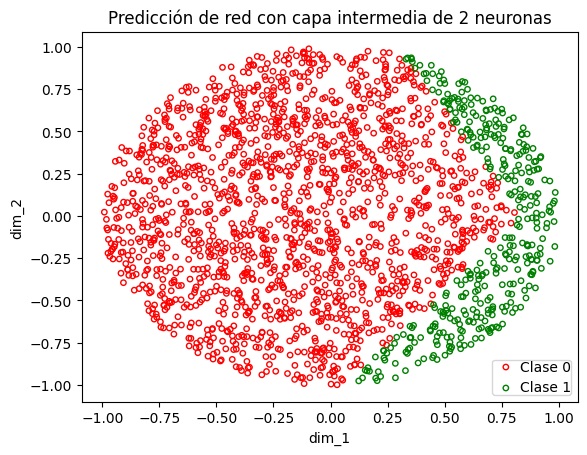

C:\Users\Certi\AppData\Local\Temp\ipykernel_27788\2214307645.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(
C:\Users\Certi\AppData\Local\Temp\ipykernel_27788\2214307645.py:15: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(


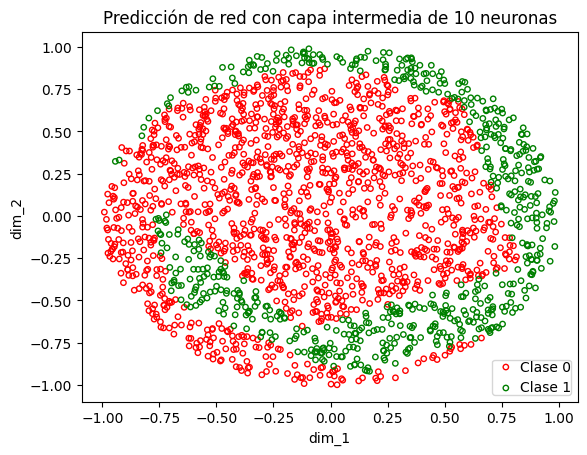

C:\Users\Certi\AppData\Local\Temp\ipykernel_27788\2214307645.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(
C:\Users\Certi\AppData\Local\Temp\ipykernel_27788\2214307645.py:15: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(


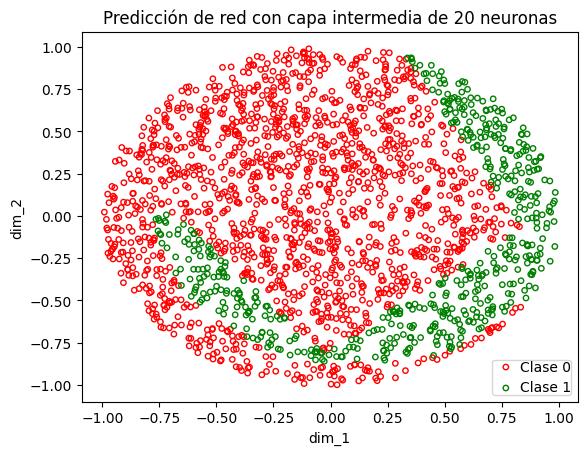

C:\Users\Certi\AppData\Local\Temp\ipykernel_27788\2214307645.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(
C:\Users\Certi\AppData\Local\Temp\ipykernel_27788\2214307645.py:15: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(


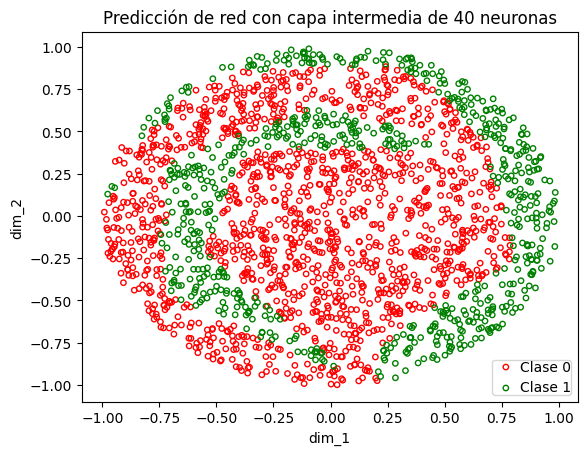

In [136]:
for k, v in redes.items():
  prediction = v.predict(X_test)
  idx = np.where(prediction == 0)
  plt.scatter(
      X_test[idx, 0],
      X_test[idx, 1],
      facecolors='none',
      edgecolors='r',
      label="Clase 0",
      cmap=plt.cm.RdYlBu,
      s=15,
  )

  idx = np.where(prediction == 1)
  plt.scatter(
      X_test[idx, 0],
      X_test[idx, 1],
      facecolors='none',
      edgecolors='g',
      label="Clase 1",
      cmap=plt.cm.RdYlBu,
      s=15,
  )

  plt.xlabel(feature_names[0])
  plt.ylabel(feature_names[1])
  plt.legend(loc="lower right", borderpad=0, handletextpad=0)
  plt.title(f'Predicción de red con capa intermedia de {k} neuronas')
  plt.show()

## Análisis

Se puede apreciar claramente como al aumentar la cantidad de nueronas se puede aproximar mejor el espiral, esto se debe a que es una forma muy compleja que mientras mas neuronas mas curvas podemos definir en el plano para separar las clases. Sin embargo las predicciones no son lo suficientemente buenas, incluso con 40 neuronas en la capa intermedia, esto creo que se debe a que no son suficientes epocas de entrenamiento o tal vez se podria solucionar una capa oculta adicional.

## Entrenamiento

In [29]:
X_data_aux, y_data_aux = cargar_csv("./data/dos_elipses.data", 2)
X_test, y_test = cargar_csv("./data/dos_elipses.test", 2)

X_data, _, y_data, _ = train_test_split(X_data_aux, y_data_aux, test_size = 0.5)
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size = 0.2)

C:\Users\Certi\AppData\Local\Temp\ipykernel_29872\1536466213.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(path, delim_whitespace=delim_whitespace, header=None)
C:\Users\Certi\AppData\Local\Temp\ipykernel_29872\1536466213.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(path, delim_whitespace=delim_whitespace, header=None)


In [30]:
#defino parámetros de la red
epocas_por_entrenamiento = 50     #numero de epocas que entrena cada vez
evaluaciones = 300
N2 = 6

momentums = [0, 0.5, 0.9]
learnings = [0.1, 0.01, 0.001]
trys = 10

In [31]:
redes_sum = {}
redes_avg = {}
best_redes = {}

for alfa in momentums:
    for lr in learnings:
        best_error = 1.0
        for i in range(trys):
            clasif = MLPClassifier(hidden_layer_sizes=(N2,), activation='logistic', solver='sgd', alpha=0.0, batch_size=1, learning_rate='constant', learning_rate_init=lr,momentum=alfa,nesterovs_momentum=False,tol=0.0,warm_start=True,max_iter=epocas_por_entrenamiento)

            best_red, error_train, error_val, error_test = entrenar_red(clasif, evaluaciones, X_train, y_train, X_val, y_val, X_test, y_test)
            
            if (alfa, lr) not in redes_sum:
                redes_sum[(alfa, lr)] = 0

            P_test = best_red.predict(X_test)
            test_error = zero_one_loss(y_test, P_test)
            redes_sum[(alfa, lr)] += test_error

            if test_error < best_error:
                best_error = test_error
                best_redes[(alfa, lr)] = {'best_error': best_error, 'best_red': best_red, 'error_train': error_train, 'error_val': error_val, 'error_test': error_test}
                
        redes_avg[(alfa, lr)] = redes_sum[(alfa, lr)] / trys

## Gráfico y tabla

In [32]:
data = {'Momentum': [], 'Learning rate': [], 'Error promedio': [], 'Error mínimo': []}

lowest_avg = 1.0
best_red = None
best_red_alfa = None
best_red_lr = None

for lr in learnings:
    for alfa in momentums:
        data['Momentum'].append(alfa)
        data['Learning rate'].append(lr)
        data['Error promedio'].append(redes_avg[(alfa, lr)])
        data['Error mínimo'].append(best_redes[(alfa, lr)]['best_error'])
        if redes_avg[(alfa, lr)] < lowest_avg:
            lowest_avg = redes_avg[(alfa, lr)]
            best_red = best_redes[(alfa, lr)]
            best_red_alfa = alfa
            best_red_lr = lr

df = pd.DataFrame(data)
print(df)

   Momentum  Learning rate  Error promedio  Error mínimo
0       0.0          0.100         0.07195        0.0135
1       0.5          0.100         0.08180        0.0145
2       0.9          0.100         0.11780        0.0490
3       0.0          0.010         0.24350        0.2435
4       0.5          0.010         0.19820        0.1695
5       0.9          0.010         0.07020        0.0125
6       0.0          0.001         0.24350        0.2435
7       0.5          0.001         0.24350        0.2435
8       0.9          0.001         0.23315        0.1900


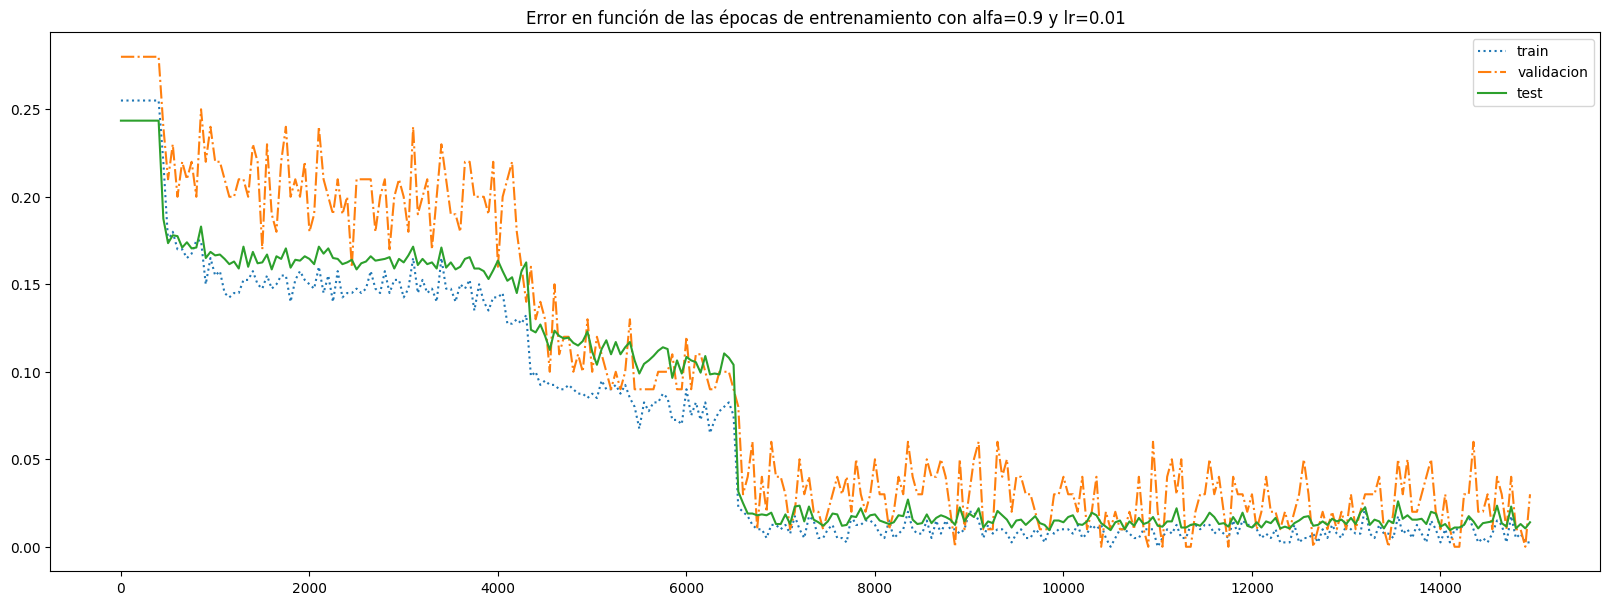

In [33]:
rango = np.array(range(evaluaciones)) * epocas_por_entrenamiento
plt.figure(figsize=(20, 7))
plt.plot(rango, best_red['error_train'], label="train", linestyle=":")
plt.plot(rango, best_red['error_val'], label="validacion", linestyle="-.")
plt.plot(rango, best_red['error_test'], label="test", linestyle="-")
plt.title(f'Error en función de las épocas de entrenamiento con alfa={best_red_alfa} y lr={best_red_lr}')
plt.legend()
plt.show()

## Análisis

En general se puede ver que los peores promedios fue cuando el learning rate fue de 0.01, esto se debe a que en cada paso la corrección del error es muy chica haciendo que se necesiten muchas mas épocas para poder obtener un aprendizaje satisfactorio.

El mejor resultado tanto en promedio como mínimo error obtenido se dió con la combinación de momentum de 0.9 y learning rate de 0.01, seguido por la combinación de momentum 0 y leaning rate de 0.1. 

Con el learning rate de 0.01 solo se obtuvo un resultado muy bueno utilizando un momentum alto, esto se da ya que para actualización de pesos esta teniendo en cuenta las actualizaciones anteriores, haciendo que los pasos no sean tan pequeños, ya que cuando el momentum es bajo con el mismo learning rate la red no aprende y recae bajo el mismo problema de cuando el learning rate es 0.001.

Cuando el learning rate es 0.1 se obtienen buenos resultados cuando el momentum es bajo, esto se debe a que al ser un learning rate muy alto le da mucha importancia a cada nuevo error calculado, si esto provoca una corrección en una dirección incorrecta, el momentum alto hace que este error se propague a las siguientes actualizaciones de pesos. 

## Carga de datos

In [12]:
X_data, y_data = cargar_csv("./data/ikeda.data", 5, delim_whitespace=True)
X_test_aux, y_test_aux = cargar_csv("./data/ikeda.test", 5, delim_whitespace=True)

X_test, _, y_test, _ = train_test_split(X_test_aux, y_test_aux, test_size = 0.58333333)

#defino parámetros de la red
epocas_por_entrenamiento=50     #numero de epocas que entrena cada vez
eta=0.01                         #learning rate
alfa=0.9                        #momentum
evaluaciones = 400
N2 = 30

redes = {}

C:\Users\Certi\AppData\Local\Temp\ipykernel_27788\1536466213.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(path, delim_whitespace=delim_whitespace, header=None)
C:\Users\Certi\AppData\Local\Temp\ipykernel_27788\1536466213.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(path, delim_whitespace=delim_whitespace, header=None)


### Relación 95%-5%

In [34]:
test_size = 0.05
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size = test_size)

regr = MLPRegressor(hidden_layer_sizes=(N2,), activation='logistic', solver='sgd', alpha=0.0, batch_size=1, learning_rate='constant', learning_rate_init=eta,momentum=alfa,nesterovs_momentum=False,tol=0.0,warm_start=True,max_iter=epocas_por_entrenamiento)

best_red, error_train, error_val, error_test = entrenar_red(regr, evaluaciones, X_train, y_train, X_val, y_val, X_test, y_test)
redes[test_size] = {'best_red': best_red, 'error_train': error_train, 'error_val': error_val, 'error_test': error_test}

### Relación 75%-25%

In [30]:
test_size = 0.25
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size = test_size)

regr = MLPRegressor(hidden_layer_sizes=(N2,), activation='logistic', solver='sgd', alpha=0.0, batch_size=1, learning_rate='constant', learning_rate_init=eta,momentum=alfa,nesterovs_momentum=False,tol=0.0,warm_start=True,max_iter=epocas_por_entrenamiento)

best_red, error_train, error_val, error_test = entrenar_red(regr, evaluaciones, X_train, y_train, X_val, y_val, X_test, y_test)
redes[test_size] = {'best_red': best_red, 'error_train': error_train, 'error_val': error_val, 'error_test': error_test}

### 50%-50%

In [26]:
test_size = 0.5
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size = test_size)

regr = MLPRegressor(hidden_layer_sizes=(N2,), activation='logistic', solver='sgd', alpha=0.0, batch_size=1, learning_rate='constant', learning_rate_init=eta,momentum=alfa,nesterovs_momentum=False,tol=0.0,warm_start=True,max_iter=epocas_por_entrenamiento)

best_red, error_train, error_val, error_test = entrenar_red(regr, evaluaciones, X_train, y_train, X_val, y_val, X_test, y_test)
redes[test_size] = {'best_red': best_red, 'error_train': error_train, 'error_val': error_val, 'error_test': error_test}

## Gráficas

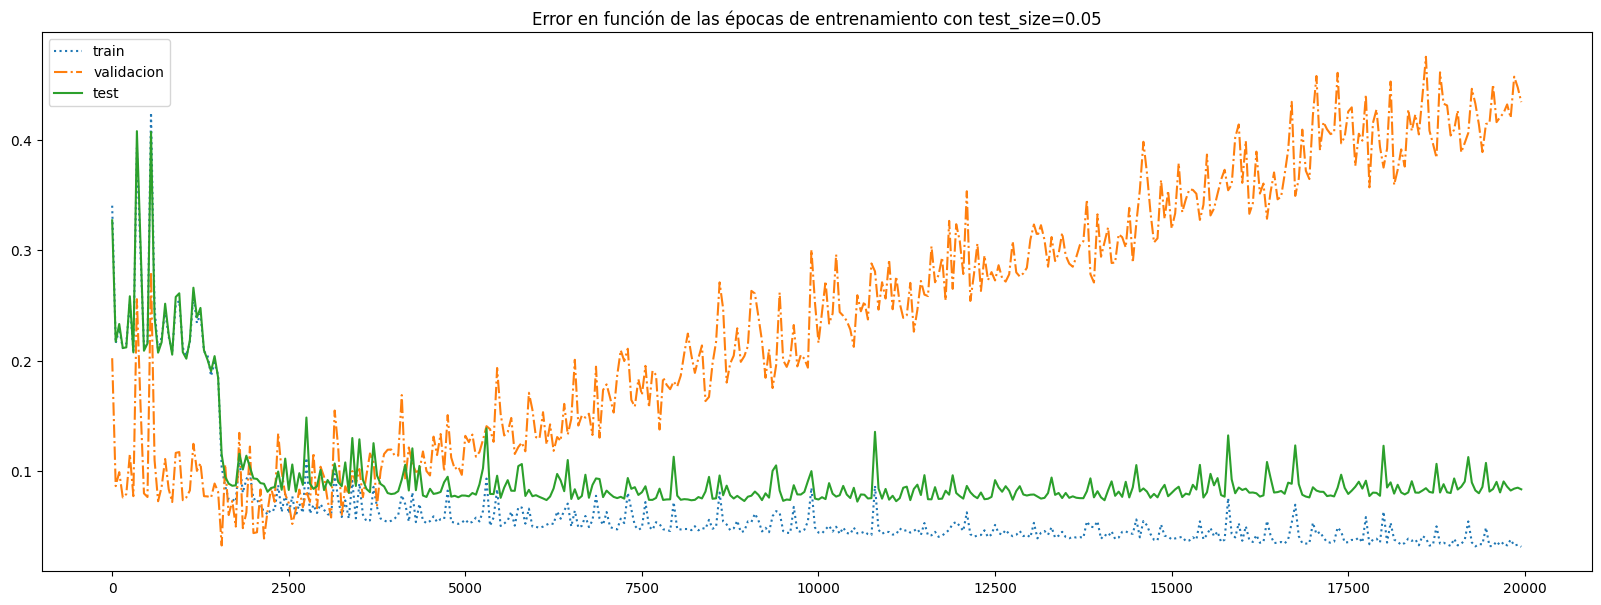

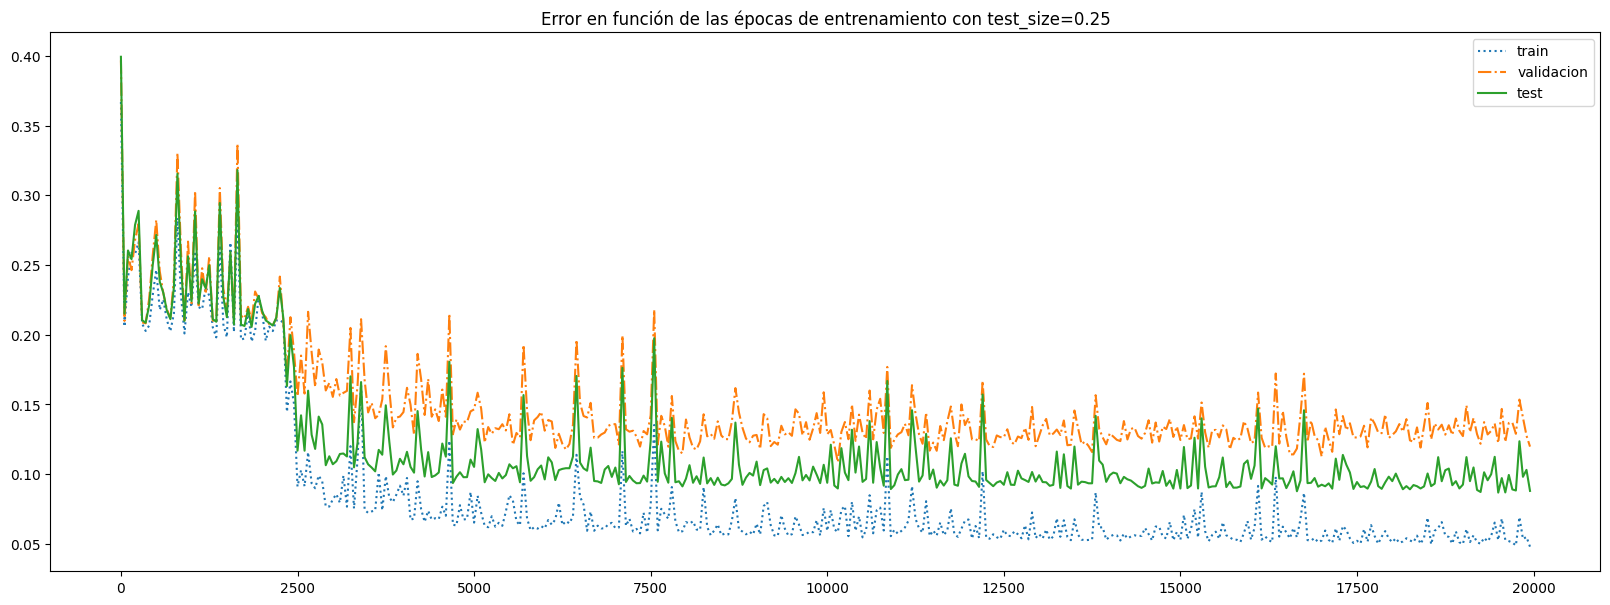

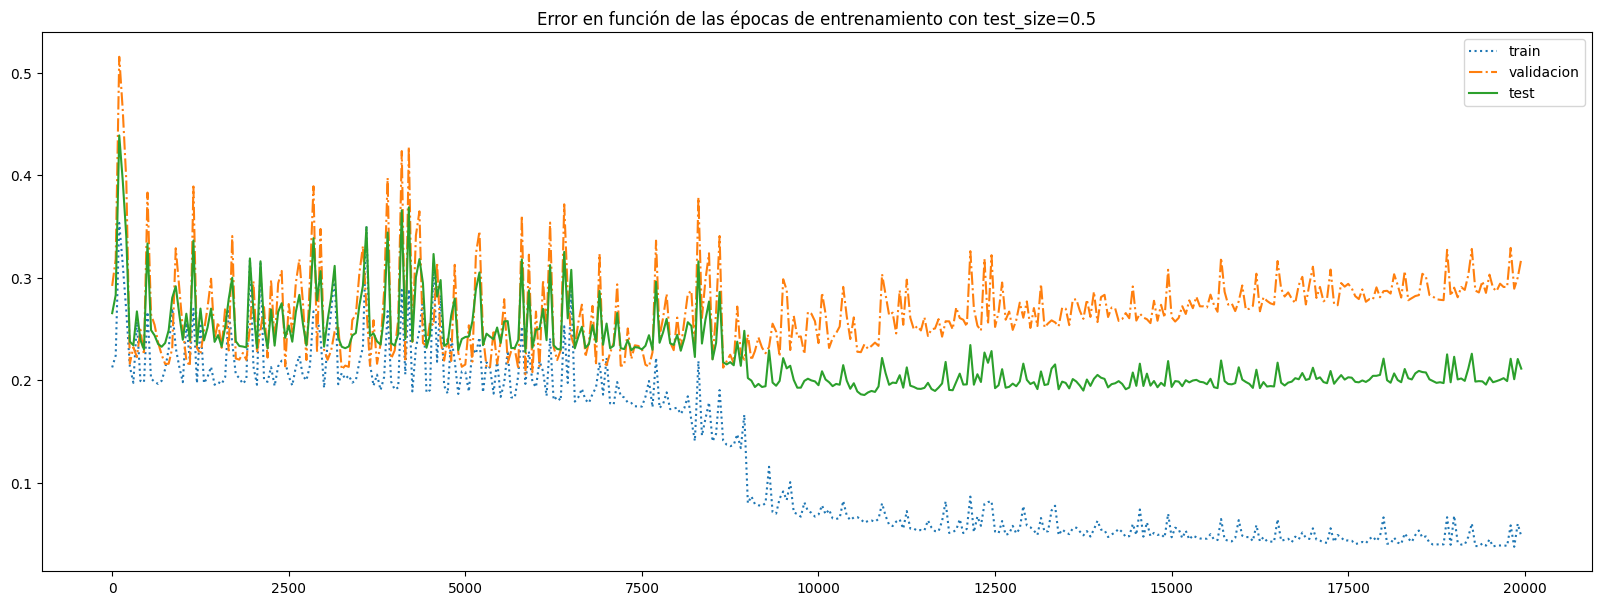

In [35]:
for k, v in redes.items():
    rango = np.array(range(evaluaciones)) * epocas_por_entrenamiento
    plt.figure(figsize=(20, 7))
    plt.plot(rango, v['error_train'], label="train", linestyle=":")
    plt.plot(rango, v['error_val'], label="validacion", linestyle="-.")
    plt.plot(rango, v['error_test'], label="test", linestyle="-")
    plt.title(f'Error en función de las épocas de entrenamiento con test_size={k}')
    plt.legend()
    plt.show()

## Análisis

Podemos ver que cuando el conjunto de validacion es bajo, como es el caso de la relación 95-5, el mismo se comporta de una forma muy errática, muy alejado del conjunto de test, por lo que no sirve un conjunto tan chico para utilizar como una muestra del mundo real y decidir si un modelo está entrenado o no en base a este. Asi y todo como el conjunto de training tuvo un buen tamaño, el error en test fue bajo.

Cuando el conjunto de validacion es un poco mas grande, como en el caso de la relacion 75-25, podemos ver que se comporta parecido al conjunto de test, no es una replica exacta pero se encuentran en la misma zona y los minimos de validación coincide con los de test. Los resultados del entrenamiento fueron muy buenos, obteniendo un error cercano a la relacion 95-5, lo que nos indica que esta proporcion es una apropiada para poder entrenar la red y a la vez tener un conjunto de validacion que se asemeje al test/realidad.

Cuando utilizamos una relacion 50-50 entre train y validación vemos que el error de test y validación es muy alto a pesar de que el error de entrenanamiento es casi cero. Esto se debe a que el conjunto de entrenamiento es muy chico, haciendo que el mismo se aprenda a la perfeccion pero obteniendo una muy mala generalización debido a la falta de datos.

## Carga de datos

In [5]:
X_train, y_train = cargar_csv("./data/ssp.data", 12)
X_test, y_test = cargar_csv("./data/ssp.test", 12)

#defino parámetros de la red
epocas_por_entrenamiento=20     #numero de epocas que entrena cada vez
eta=0.05                         #learning rate
alfa=0.3                        #momentum
evaluaciones = 4000
N2 = 6

gamma_values = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1]

redes = {}

C:\Users\Certi\AppData\Local\Temp\ipykernel_19332\1536466213.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(path, delim_whitespace=delim_whitespace, header=None)
C:\Users\Certi\AppData\Local\Temp\ipykernel_19332\1536466213.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(path, delim_whitespace=delim_whitespace, header=None)



## Entrenamiento

In [6]:
for gamma in gamma_values:
    regr = MLPRegressor(hidden_layer_sizes=(N2,), activation='logistic', solver='sgd', alpha=gamma, batch_size=1, learning_rate='constant', learning_rate_init=eta,momentum=alfa,nesterovs_momentum=False,tol=0.0,warm_start=True,max_iter=epocas_por_entrenamiento)

    best_red, error_train, error_test, weight_sum = entrenar_red_weight_decay(regr, evaluaciones, X_train, y_train, X_test, y_test)
    redes[gamma] = {'best_red': best_red, 'error_train': error_train, 'error_test': error_test, 'weight_sum': weight_sum}

## Gráficos

El que elijo es el de 10^-4, ya que este es el que presenta el menor error en el conjunto de test sin un gran sobreajuste.

Como ejemplos de sobreajuste tenemos 10^-6.

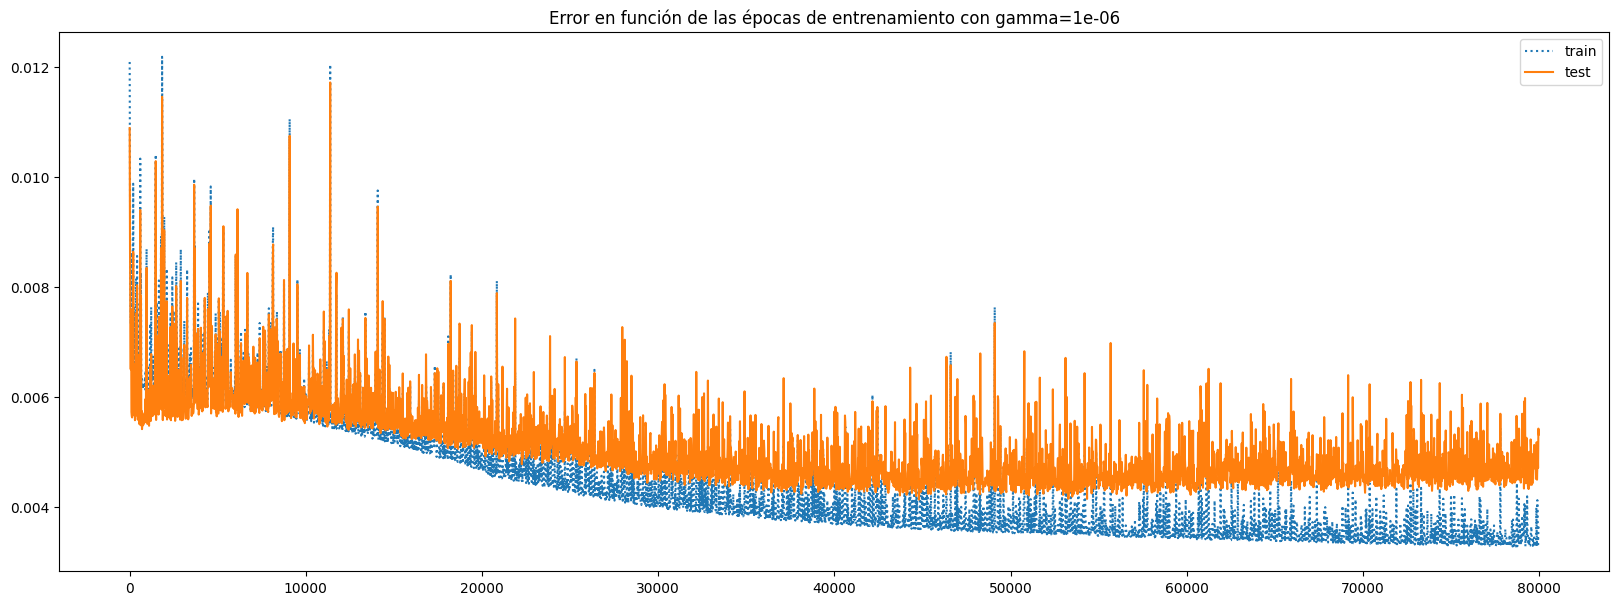

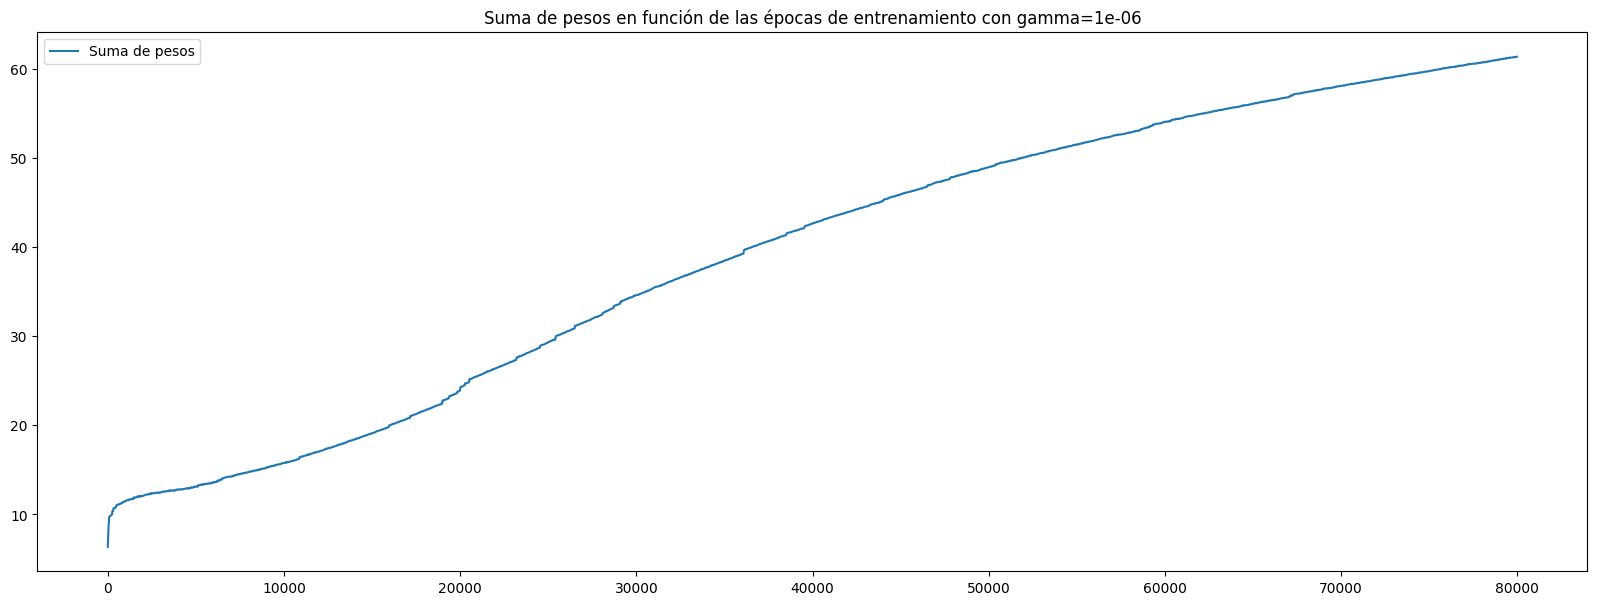

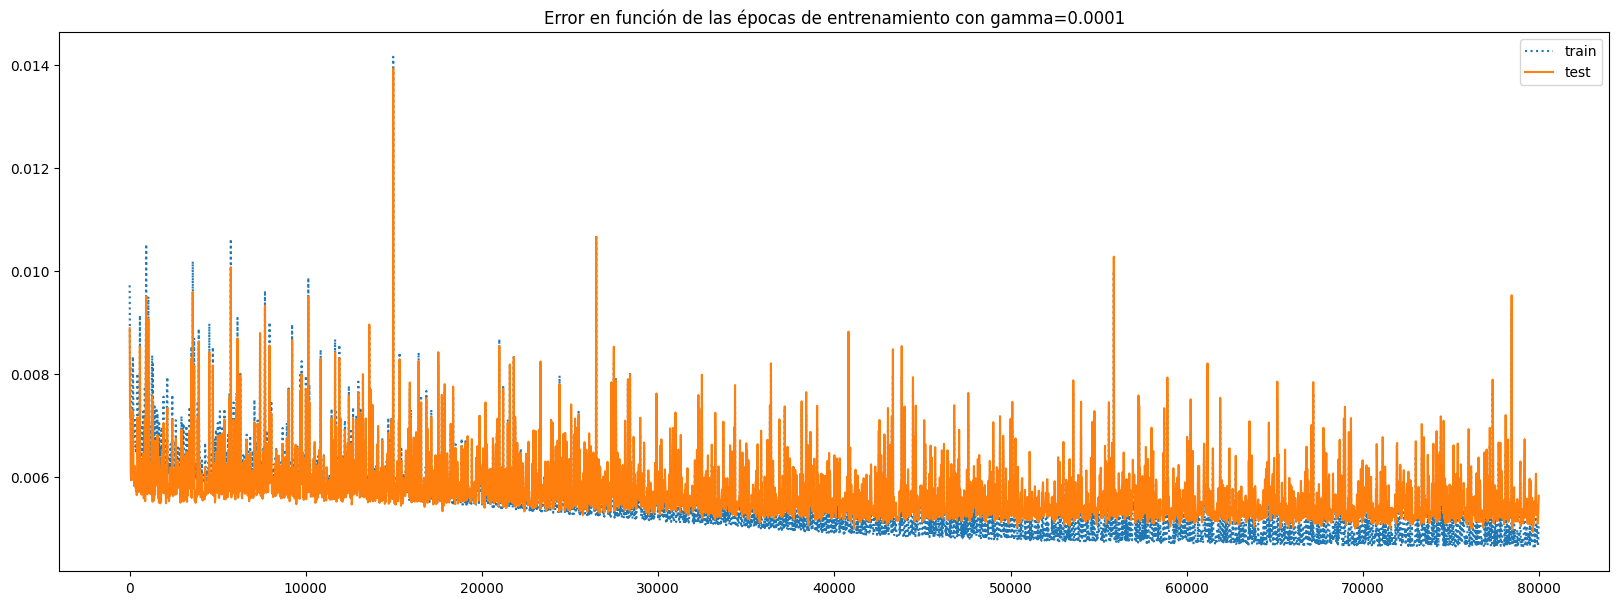

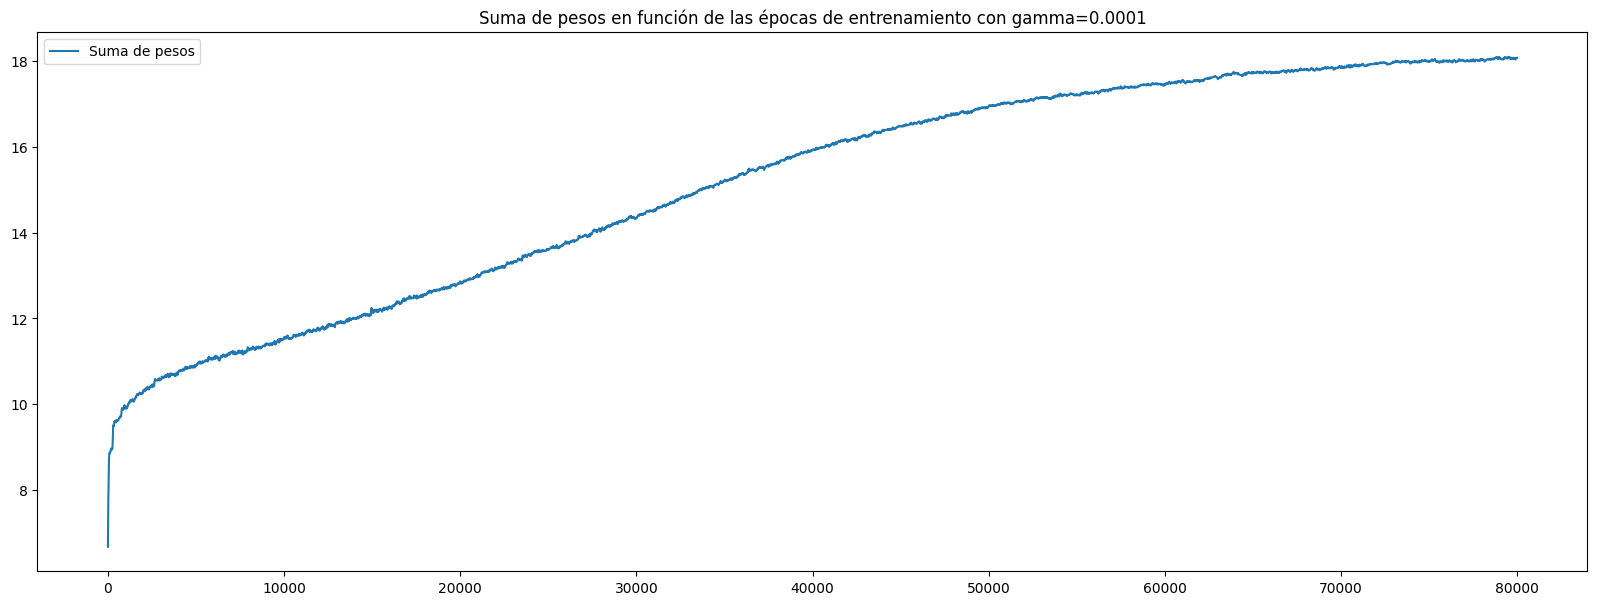

In [8]:
chosen_gammas = [0.0001, 0.000001]
for k, v in redes.items():
    if k not in chosen_gammas:
        continue
    rango = np.array(range(evaluaciones)) * epocas_por_entrenamiento
    plt.figure(figsize=(20, 7))
    plt.plot(rango, v['error_train'], label="train", linestyle=":")
    plt.plot(rango, v['error_test'], label="test", linestyle="-")
    plt.title(f'Error en función de las épocas de entrenamiento con gamma={k}')
    plt.legend()
    plt.show()

    plt.figure(figsize=(20, 7))
    plt.plot(rango, v['weight_sum'], label="Suma de pesos")
    plt.title(f'Suma de pesos en función de las épocas de entrenamiento con gamma={k}')
    plt.legend()
    plt.show()

## Análisis

Podemos ver que cuando el gamma es 10^-6 los pesos cuadraticos son mas del triple que los que se tienen cuando es 10^-4. Es por esto mismo que se puede notar un sobreajuste, podemos ver claramente como el error de test sube a medida que el de train baja y se alejan.

Cuando gamma toma un valor de 10^-4 se puede ver que hacia las ultimas epocas el error de train baja mas que el de test, pero no se puede apreciar sobreajuste. Elegí este valor debido a que a pesar de que hacia el final de las epocas hubiera un alejamiento, fue el valor que logro los mejores resultados en las redes.

Cuando el gamma es muy alto hace que se penalice demasiado el aumento de los pesos, haciendo que la red no aprenda, llegando al caso extremo de gamma igual a 1 los pesos no se muevan de 0.

Este método de control me parece muy util ya que al no necesitar conjunto de validacion tenemos mas datos para entrenar. Sumado a esto, como en cada paso no necesitamos guardar la mejor red hasta el momento, lo cual es muy eficiente ya que no es necesario hacer un deepcopy cada vez que encontramos una red mejor. El problema que le encuentro es que no tenemos forma de saber hasta cuando es necesario entrenar una red si no tenemos un conjunto para validar.

# Ejercicio 1

## Funciones de generación

In [10]:
def covM(d, C):
  return np.identity(d)*([(C*np.sqrt(d))**2]*d)

def diagonales(n, d, C):
  n0 = int(n/2)
  #Clase0
  c0 = [np.append(x, 0) for x in np.random.multivariate_normal([-1]*d, covM(d, C), n0)]
  #Clase1
  c1 = [np.append(x, 1) for x in np.random.multivariate_normal([1]*d, covM(d, C), n-n0)]

  flist = c0 + c1
  # Crear DataFrame
  df = pd.DataFrame(flist, columns=[f'dim_{i}' for i in range(d)] + ['class'])
  return df

def covM2(d, C):
  return np.identity(d)*([C**2]*d)

def paralelas(n, d, C):
  n0 = int(n/2)
  #Clase0
  c0 = [np.append(x, 0) for x in np.random.multivariate_normal([-1] + [0]*(d-1), covM2(d, C), n0)]
  #Clase1
  c1 = [np.append(x, 1) for x in np.random.multivariate_normal([1] + [0]*(d-1), covM2(d, C), n-n0)]

  flist = c0 + c1
  # Crear DataFrame
  df = pd.DataFrame(flist, columns=[f'dim_{i}' for i in range(d)] + ['class'])
  return df

## Valores generales

In [11]:
C = 0.78
n_training = 250
n_testing = 10000
d_values = [2, 4, 8, 16, 32]
count_for_avg = 20

#defino parámetros de la red
epocas_por_entrenamiento=50     #numero de epocas que entrena cada vez
eta=0.1                         #learning rate
alfa=0.9                        #momentum
evaluaciones = 400
gamma = 0.0001
N2 = 6

## Entrenamiento

### Diagonales

In [12]:
errors_diagonales_trees = {}
errors_diagonales_redes = {}
errors_diagonales_naive_bayes = {}

for d in d_values:
  errors_list_trees = []
  errors_list_redes = []
  errors_list_naive_bayes = []

  df_test = diagonales(n_testing, d, C)
  y_test = df_test["class"].to_numpy()
  X_test = df_test.drop(columns=["class"]).to_numpy()

  for i in range(count_for_avg):
    print(f"Diagonales, d={d}, iteración={i}")
    df_train = diagonales(n_training, d, C)
    y_train = df_train["class"].to_numpy()
    X_train = df_train.drop(columns=["class"]).to_numpy()

    # Naive Bayes
    clf = GaussianNB()
    clf.fit(X_train, y_train)

    predict_test = clf.predict(X_test)
    accuracy_test = accuracy_score(y_test, predict_test)

    predict_train = clf.predict(X_train)
    accuracy_train = accuracy_score(y_train, predict_train)

    errors_list_naive_bayes.append({'error_test': 1-accuracy_test, 'error_train': 1-accuracy_train})

    # Redes
    clasif = MLPClassifier(hidden_layer_sizes=(N2,), activation='logistic', solver='sgd', alpha=gamma, batch_size=1, learning_rate='constant', learning_rate_init=eta,momentum=alfa,nesterovs_momentum=False,tol=0.0,warm_start=True,max_iter=epocas_por_entrenamiento)

    best_red, error_train, error_test, _ = entrenar_red_weight_decay(clasif, evaluaciones, X_train, y_train, X_test, y_test)

    errors_list_redes.append({'error_test': error_test[-1], 'error_train': error_train[-1]})

    # Árboles
    t = DecisionTreeClassifier(criterion="entropy",min_impurity_decrease=0.002,random_state=0,min_samples_leaf=5)
    t.fit(X_train, y_train)

    predict_test = t.predict(X_test)
    accuracy_test = accuracy_score(y_test, predict_test)

    predict_train = t.predict(X_train)
    accuracy_train = accuracy_score(y_train, predict_train)

    errors_list_trees.append({'error_test': 1-accuracy_test, 'error_train': 1-accuracy_train})

  errors_diagonales_redes[d] = errors_list_redes
  errors_diagonales_trees[d] = errors_list_trees
  errors_diagonales_naive_bayes[d] = errors_list_naive_bayes

Diagonales, d=2, iteración=0
Diagonales, d=2, iteración=1
Diagonales, d=2, iteración=2
Diagonales, d=2, iteración=3
Diagonales, d=2, iteración=4
Diagonales, d=2, iteración=5
Diagonales, d=2, iteración=6
Diagonales, d=2, iteración=7
Diagonales, d=2, iteración=8
Diagonales, d=2, iteración=9
Diagonales, d=2, iteración=10
Diagonales, d=2, iteración=11
Diagonales, d=2, iteración=12
Diagonales, d=2, iteración=13
Diagonales, d=2, iteración=14
Diagonales, d=2, iteración=15
Diagonales, d=2, iteración=16
Diagonales, d=2, iteración=17
Diagonales, d=2, iteración=18
Diagonales, d=2, iteración=19
Diagonales, d=4, iteración=0
Diagonales, d=4, iteración=1
Diagonales, d=4, iteración=2
Diagonales, d=4, iteración=3
Diagonales, d=4, iteración=4
Diagonales, d=4, iteración=5
Diagonales, d=4, iteración=6
Diagonales, d=4, iteración=7
Diagonales, d=4, iteración=8
Diagonales, d=4, iteración=9
Diagonales, d=4, iteración=10
Diagonales, d=4, iteración=11
Diagonales, d=4, iteración=12
Diagonales, d=4, iteración=13


c:\Users\Certi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Diagonales, d=32, iteración=13
Diagonales, d=32, iteración=14
Diagonales, d=32, iteración=15
Diagonales, d=32, iteración=16
Diagonales, d=32, iteración=17
Diagonales, d=32, iteración=18
Diagonales, d=32, iteración=19


In [14]:
errors_test_diagonales_tree_avg = []
errors_train_diagonales_tree_avg = []
for k, l in errors_diagonales_trees.items():
  sum_train = 0
  sum_test = 0
  for e in l:
    sum_train += e['error_train']
    sum_test += e['error_test']
  errors_test_diagonales_tree_avg.append(sum_test/count_for_avg)
  errors_train_diagonales_tree_avg.append(sum_train/count_for_avg)

errors_test_diagonales_red_avg = []
errors_train_diagonales_red_avg = []
for k, l in errors_diagonales_redes.items():
  sum_train = 0
  sum_test = 0
  for e in l:
    sum_train += e['error_train']
    sum_test += e['error_test']
  errors_test_diagonales_red_avg.append(sum_test/count_for_avg)
  errors_train_diagonales_red_avg.append(sum_train/count_for_avg)

errors_test_diagonales_naive_bayes_avg = []
errors_train_diagonales_naive_bayes_avg = []
for k, l in errors_diagonales_naive_bayes.items():
  sum_train = 0
  sum_test = 0
  for e in l:
    sum_train += e['error_train']
    sum_test += e['error_test']
  errors_test_diagonales_naive_bayes_avg.append(sum_test/count_for_avg)
  errors_train_diagonales_naive_bayes_avg.append(sum_train/count_for_avg)

### Paralelas

In [15]:
errors_paralelas_redes = {}
errors_paralelas_trees = {}
errors_paralelas_naive_bayes = {}

for d in d_values:
  errors_list_trees = []
  errors_list_redes = []
  errors_list_naive_bayes = []

  df_test = paralelas(n_testing, d, C)
  y_test = df_test["class"].to_numpy()
  X_test = df_test.drop(columns=["class"]).to_numpy()

  for i in range(count_for_avg):
    print(f"Paralelas, d={d}, iteración={i}")
    df_train = paralelas(n_training, d, C)
    y_train = df_train["class"].to_numpy()
    X_train = df_train.drop(columns=["class"]).to_numpy()

    # Naive Bayes
    clf = GaussianNB()
    clf.fit(X_train, y_train)

    predict_test = clf.predict(X_test)
    accuracy_test = accuracy_score(y_test, predict_test)

    predict_train = clf.predict(X_train)
    accuracy_train = accuracy_score(y_train, predict_train)

    errors_list_naive_bayes.append({'error_test': 1-accuracy_test, 'error_train': 1-accuracy_train})

    # Redes
    clasif = MLPClassifier(hidden_layer_sizes=(N2,), activation='logistic', solver='sgd', alpha=gamma, batch_size=1, learning_rate='constant', learning_rate_init=eta,momentum=alfa,nesterovs_momentum=False,tol=0.0,warm_start=True,max_iter=epocas_por_entrenamiento)

    best_red, error_train, error_test, _ = entrenar_red_weight_decay(clasif, evaluaciones, X_train, y_train, X_test, y_test)

    errors_list_redes.append({'error_test': error_test[-1], 'error_train': error_train[-1]})

    # Árboles
    t = DecisionTreeClassifier(criterion="entropy",min_impurity_decrease=0.002,random_state=0,min_samples_leaf=5)
    t.fit(X_train, y_train)

    predict_test = t.predict(X_test)
    accuracy_test = accuracy_score(y_test, predict_test)

    predict_train = t.predict(X_train)
    accuracy_train = accuracy_score(y_train, predict_train)

    errors_list_trees.append({'error_test': 1-accuracy_test, 'error_train': 1-accuracy_train})
  
  errors_paralelas_redes[d] = errors_list_redes
  errors_paralelas_trees[d] = errors_list_trees
  errors_paralelas_naive_bayes[d] = errors_list_naive_bayes

Paralelas, d=2, iteración=0
Paralelas, d=2, iteración=1
Paralelas, d=2, iteración=2
Paralelas, d=2, iteración=3
Paralelas, d=2, iteración=4
Paralelas, d=2, iteración=5
Paralelas, d=2, iteración=6
Paralelas, d=2, iteración=7
Paralelas, d=2, iteración=8
Paralelas, d=2, iteración=9
Paralelas, d=2, iteración=10
Paralelas, d=2, iteración=11
Paralelas, d=2, iteración=12
Paralelas, d=2, iteración=13
Paralelas, d=2, iteración=14
Paralelas, d=2, iteración=15
Paralelas, d=2, iteración=16
Paralelas, d=2, iteración=17
Paralelas, d=2, iteración=18
Paralelas, d=2, iteración=19
Paralelas, d=4, iteración=0
Paralelas, d=4, iteración=1
Paralelas, d=4, iteración=2
Paralelas, d=4, iteración=3
Paralelas, d=4, iteración=4
Paralelas, d=4, iteración=5
Paralelas, d=4, iteración=6
Paralelas, d=4, iteración=7
Paralelas, d=4, iteración=8
Paralelas, d=4, iteración=9
Paralelas, d=4, iteración=10
Paralelas, d=4, iteración=11
Paralelas, d=4, iteración=12
Paralelas, d=4, iteración=13
Paralelas, d=4, iteración=14
Paral

In [16]:
errors_test_paralelas_tree_avg = []
errors_train_paralelas_tree_avg = []
for k, l in errors_paralelas_trees.items():
  sum_train = 0
  sum_test = 0
  for e in l:
    sum_train += e['error_train']
    sum_test += e['error_test']
  errors_test_paralelas_tree_avg.append(sum_test/count_for_avg)
  errors_train_paralelas_tree_avg.append(sum_train/count_for_avg)

errors_test_paralelas_red_avg = []
errors_train_paralelas_red_avg = []
for k, l in errors_paralelas_redes.items():
  sum_train = 0
  sum_test = 0
  for e in l:
    sum_train += e['error_train']
    sum_test += e['error_test']
  errors_test_paralelas_red_avg.append(sum_test/count_for_avg)
  errors_train_paralelas_red_avg.append(sum_train/count_for_avg)

errors_test_paralelas_naive_bayes_avg = []
errors_train_paralelas_naive_bayes_avg = []
for k, l in errors_paralelas_naive_bayes.items():
  sum_train = 0
  sum_test = 0
  for e in l:
    sum_train += e['error_train']
    sum_test += e['error_test']
  errors_test_paralelas_naive_bayes_avg.append(sum_test/count_for_avg)
  errors_train_paralelas_naive_bayes_avg.append(sum_train/count_for_avg)

## Gráficas

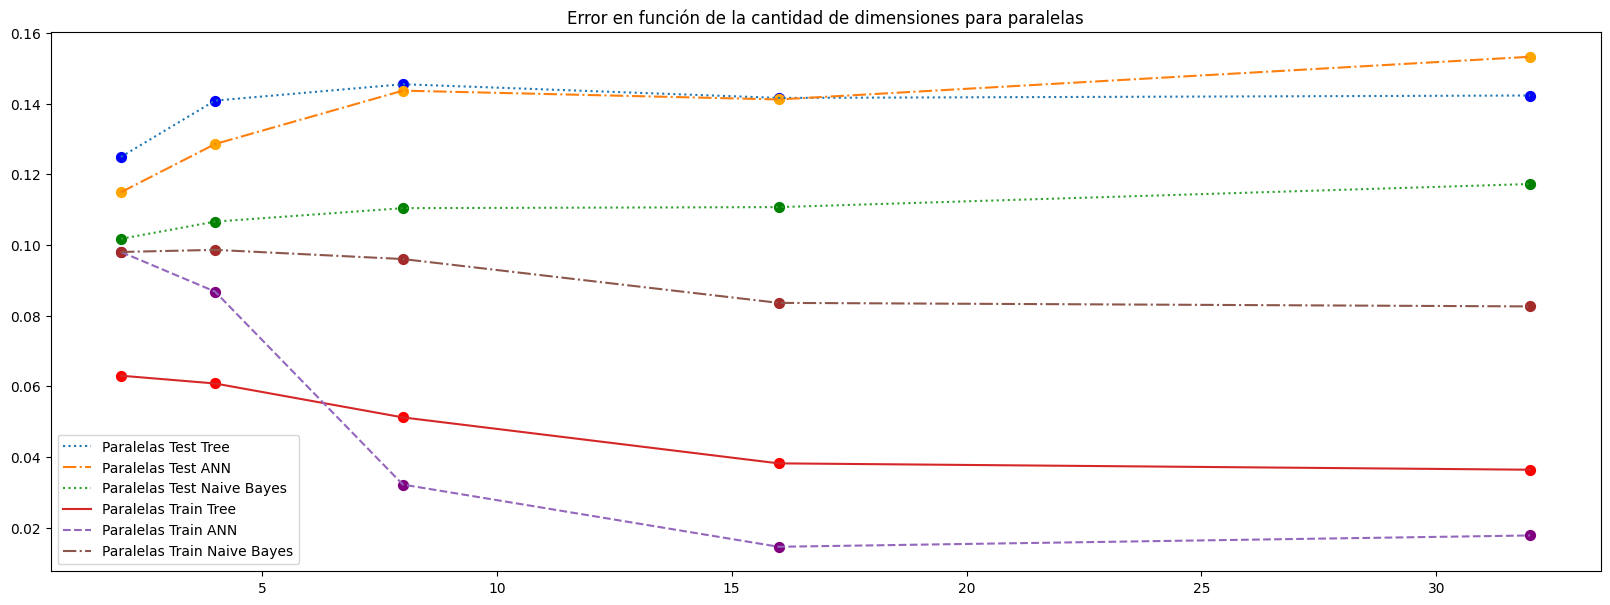

In [20]:
plt.figure(figsize=(20, 7))
plt.plot(d_values, errors_test_paralelas_tree_avg, label="Paralelas Test Tree", linestyle=":")
plt.plot(d_values, errors_test_paralelas_red_avg, label="Paralelas Test ANN", linestyle="-.")
plt.plot(d_values, errors_test_paralelas_naive_bayes_avg, label="Paralelas Test Naive Bayes", linestyle=":")
plt.plot(d_values, errors_train_paralelas_tree_avg, label="Paralelas Train Tree", linestyle="-")
plt.plot(d_values, errors_train_paralelas_red_avg, label="Paralelas Train ANN", linestyle="--")
plt.plot(d_values, errors_train_paralelas_naive_bayes_avg, label="Paralelas Train Naive Bayes", linestyle="-.")

plt.scatter(d_values, errors_test_paralelas_tree_avg, color='blue', s=50)  # puntos en azul
plt.scatter(d_values, errors_test_paralelas_red_avg, color='orange', s=50)  # puntos en naranja
plt.scatter(d_values, errors_test_paralelas_naive_bayes_avg, color='green', s=50)  # puntos en verde
plt.scatter(d_values, errors_train_paralelas_tree_avg, color='red', s=50)  # puntos en rojo
plt.scatter(d_values, errors_train_paralelas_red_avg, color='purple', s=50)  
plt.scatter(d_values, errors_train_paralelas_naive_bayes_avg, color='brown', s=50)  

plt.title(f'Error en función de la cantidad de dimensiones para paralelas')
plt.legend()
plt.show()

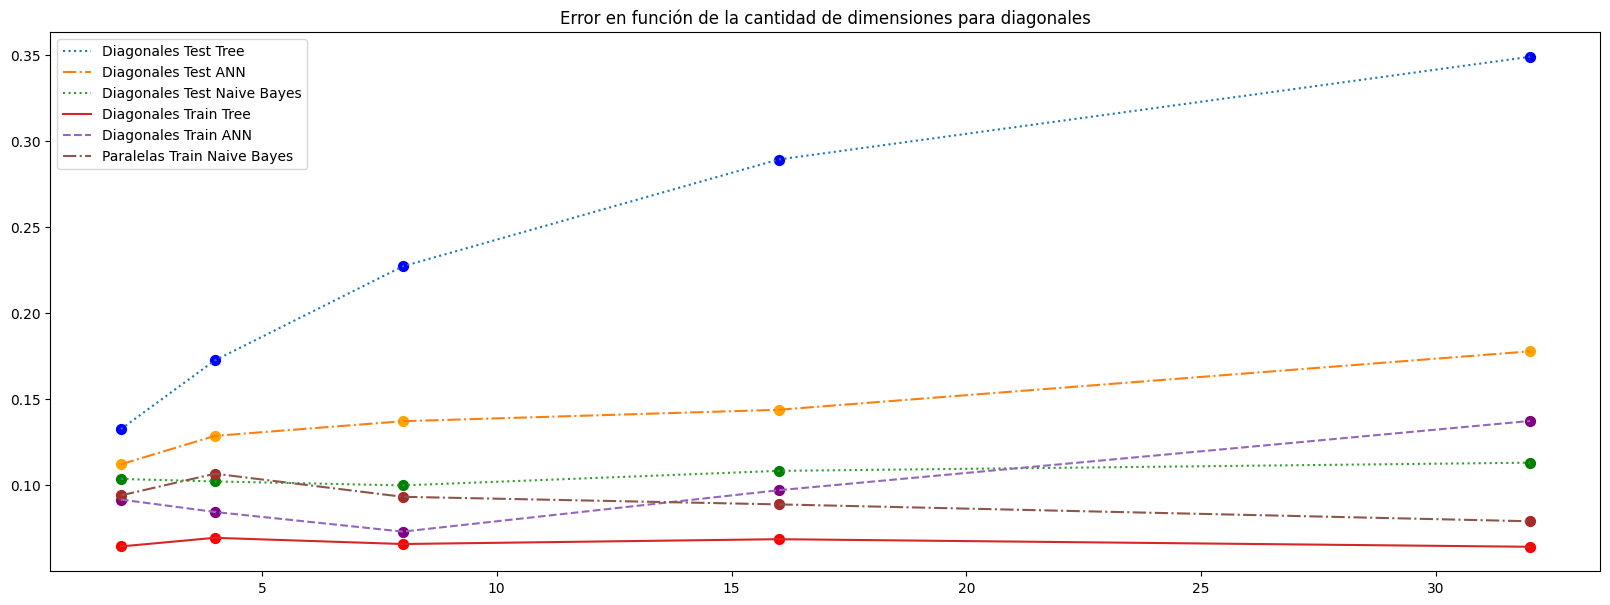

In [22]:
plt.figure(figsize=(20, 7))
plt.plot(d_values, errors_test_diagonales_tree_avg, label="Diagonales Test Tree", linestyle=":")
plt.plot(d_values, errors_test_diagonales_red_avg, label="Diagonales Test ANN", linestyle="-.")
plt.plot(d_values, errors_test_diagonales_naive_bayes_avg, label="Diagonales Test Naive Bayes", linestyle=":")
plt.plot(d_values, errors_train_diagonales_tree_avg, label="Diagonales Train Tree", linestyle="-")
plt.plot(d_values, errors_train_diagonales_red_avg, label="Diagonales Train ANN", linestyle="--")
plt.plot(d_values, errors_train_diagonales_naive_bayes_avg, label="Paralelas Train Naive Bayes", linestyle="-.")

plt.scatter(d_values, errors_test_diagonales_tree_avg, color='blue', s=50)  # puntos en azul
plt.scatter(d_values, errors_test_diagonales_red_avg, color='orange', s=50)  # puntos en naranja
plt.scatter(d_values, errors_test_diagonales_naive_bayes_avg, color='green', s=50)  # puntos en verde
plt.scatter(d_values, errors_train_diagonales_tree_avg, color='red', s=50)  # puntos en rojo
plt.scatter(d_values, errors_train_diagonales_red_avg, color='purple', s=50)  
plt.scatter(d_values, errors_train_diagonales_naive_bayes_avg, color='brown', s=50)  

plt.title(f'Error en función de la cantidad de dimensiones para diagonales')
plt.legend()
plt.show()

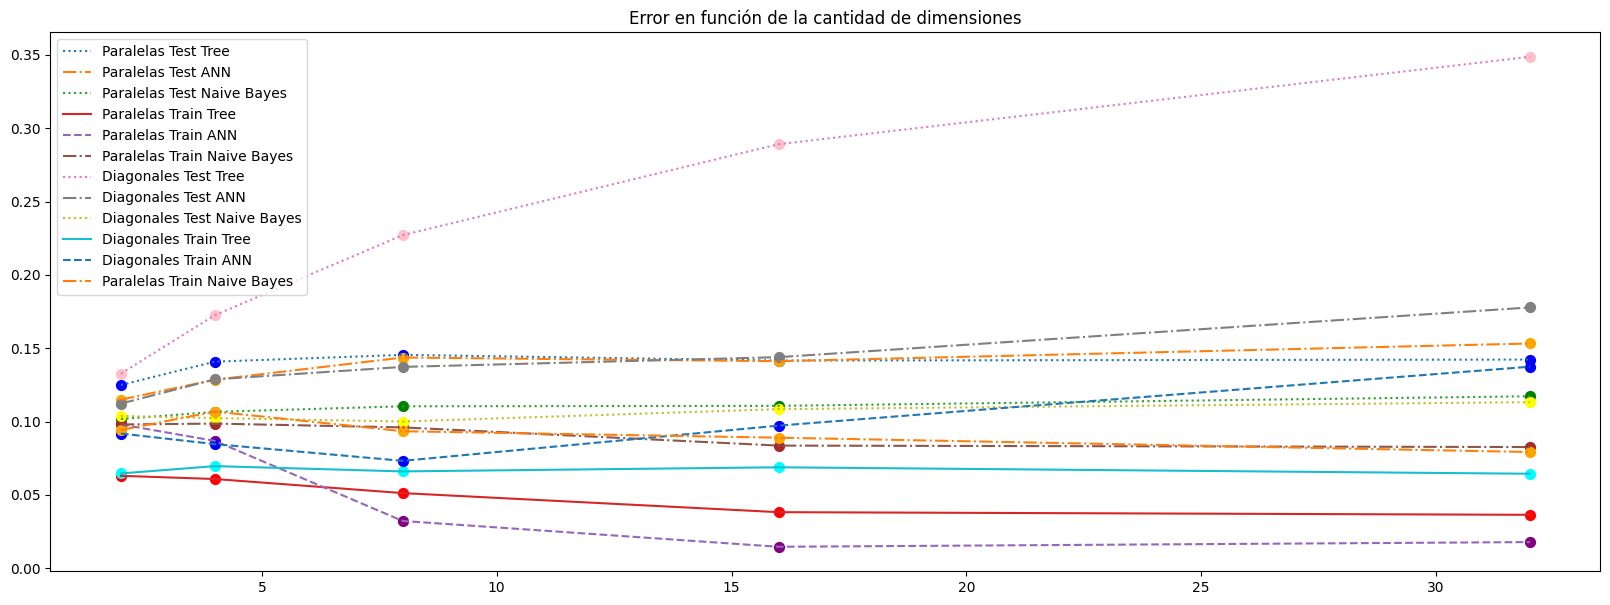

In [35]:
plt.figure(figsize=(20, 7))
plt.plot(d_values, errors_test_paralelas_tree_avg, label="Paralelas Test Tree", linestyle=":")
plt.plot(d_values, errors_test_paralelas_red_avg, label="Paralelas Test ANN", linestyle="-.")
plt.plot(d_values, errors_test_paralelas_naive_bayes_avg, label="Paralelas Test Naive Bayes", linestyle=":")
plt.plot(d_values, errors_train_paralelas_tree_avg, label="Paralelas Train Tree", linestyle="-")
plt.plot(d_values, errors_train_paralelas_red_avg, label="Paralelas Train ANN", linestyle="--")
plt.plot(d_values, errors_train_paralelas_naive_bayes_avg, label="Paralelas Train Naive Bayes", linestyle="-.")
plt.plot(d_values, errors_test_diagonales_tree_avg, label="Diagonales Test Tree", linestyle=":")
plt.plot(d_values, errors_test_diagonales_red_avg, label="Diagonales Test ANN", linestyle="-.")
plt.plot(d_values, errors_test_diagonales_naive_bayes_avg, label="Diagonales Test Naive Bayes", linestyle=":")
plt.plot(d_values, errors_train_diagonales_tree_avg, label="Diagonales Train Tree", linestyle="-")
plt.plot(d_values, errors_train_diagonales_red_avg, label="Diagonales Train ANN", linestyle="--")
plt.plot(d_values, errors_train_diagonales_naive_bayes_avg, label="Paralelas Train Naive Bayes", linestyle="-.")

plt.scatter(d_values, errors_test_paralelas_tree_avg, color='blue', s=50)  
plt.scatter(d_values, errors_test_paralelas_red_avg, color='orange', s=50)  
plt.scatter(d_values, errors_test_paralelas_naive_bayes_avg, color='green', s=50)  
plt.scatter(d_values, errors_train_paralelas_tree_avg, color='red', s=50) 
plt.scatter(d_values, errors_train_paralelas_red_avg, color='purple', s=50)  
plt.scatter(d_values, errors_train_paralelas_naive_bayes_avg, color='brown', s=50)  
plt.scatter(d_values, errors_test_diagonales_tree_avg, color='pink', s=50)
plt.scatter(d_values, errors_test_diagonales_red_avg, color='grey', s=50)  
plt.scatter(d_values, errors_test_diagonales_naive_bayes_avg, color='yellow', s=50)
plt.scatter(d_values, errors_train_diagonales_tree_avg, color='cyan', s=50)
plt.scatter(d_values, errors_train_diagonales_red_avg, color='blue', s=50)
plt.scatter(d_values, errors_train_diagonales_naive_bayes_avg, color='orange', s=50)

plt.title(f'Error en función de la cantidad de dimensiones')
plt.legend()
plt.show()

## Análisis

